# LightGBM
## Pneumonia Recognition
---


The images in this database are grayscale images that fall into one of two classes: `Normal` or `Pneumonia`. A example is pictured below.

<img src='data/test/Normal/IM-0001-0001.jpeg' width=20% height=20% />

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.decomposition import PCA
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [2]:
# Using pytorch to convert images
datapath = 'data/'
   
trainTransforms = testTransforms = transforms.Compose([transforms.Resize((120,120)), 
                                                       transforms.ToTensor()])

trainData = datasets.ImageFolder(datapath + '/train', transform=trainTransforms)
testData = datasets.ImageFolder(datapath + '/test', transform=testTransforms)

In [3]:
def image_to_df(tensor):
    
    df = pd.DataFrame()
    
    for data, target in tqdm(iter(tensor)):
        
        temp_df = pd.DataFrame( data.numpy().reshape(1,-1) )
        temp_df['target'] = target
        
        df = df.append(temp_df)
        
    else:
        df = df.reset_index()
        df = df.drop(columns='index')
        
        return df

In [4]:
dataTrain = image_to_df(trainData)

5216it [09:42,  8.95it/s]


In [5]:
dataTrain.shape

(5216, 43201)

In [6]:
dataTrain.head()

,0,1,2,3,4,5,6,7,8,9,...,43191,43192,43193,43194,43195,43196,43197,43198,43199,target
0,0.082353,0.074510,0.078431,0.180392,0.239216,0.274510,0.301961,0.337255,0.352941,0.364706,...,0.317647,0.325490,0.333333,0.341176,0.349020,0.352941,0.360784,0.360784,0.364706,0
1,0.074510,0.109804,0.133333,0.152941,0.176471,0.184314,0.196078,0.282353,0.364706,0.368627,...,0.074510,0.023529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,0.000000,0.007843,0.070588,0.117647,0.156863,0.184314,0.231373,0.270588,0.294118,0.305882,...,0.192157,0.086275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003922,0
3,0.164706,0.192157,0.215686,0.243137,0.282353,0.305882,0.325490,0.345098,0.368627,0.392157,...,0.117647,0.003922,0.003922,0.015686,0.031373,0.039216,0.039216,0.043137,0.043137,0
4,0.301961,0.274510,0.227451,0.176471,0.129412,0.105882,0.105882,0.109804,0.117647,0.125490,...,0.286275,0.298039,0.152941,0.007843,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [26]:
X = dataTrain.drop(columns='target')
y_train = dataTrain.target

In [8]:
print(X.shape)
print(y.shape)

(5216, 43200)
(5216,)


In [9]:
pca = PCA(100)
myPca = pca.fit(X)    

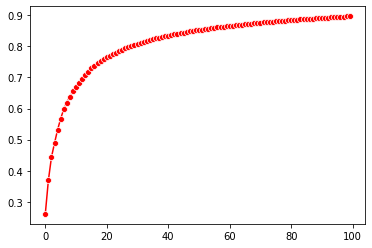

In [16]:
sns.lineplot(y = np.cumsum(myPca.explained_variance_ratio_), x = list(range(100)), marker='o', color='r')

In [17]:
# Consigo explicar 82% do meu problema com 36 colunas.
np.cumsum(myPca.explained_variance_ratio_[:36])

array([0.26109082, 0.36880475, 0.4431952 , 0.4888737 , 0.5316558 ,
       0.5675893 , 0.5976585 , 0.6193521 , 0.63847095, 0.6552039 ,
       0.6693631 , 0.682726  , 0.6951231 , 0.7073628 , 0.7186375 ,
       0.72891617, 0.7375679 , 0.7451255 , 0.7519525 , 0.75852174,
       0.76460487, 0.7703058 , 0.775222  , 0.7800894 , 0.7847943 ,
       0.7893992 , 0.79369694, 0.7978533 , 0.80171776, 0.8052222 ,
       0.8085627 , 0.81185615, 0.8149411 , 0.81782025, 0.82057184,
       0.8232175 ], dtype=float32)

In [36]:
# Definindo um PCA de 36.
pca = PCA(36)
myPca = pca.fit(X)    

In [19]:
X_pca = pca.fit_transform(X)

In [20]:
X_pca.shape

(5216, 36)

In [21]:
y.shape

(5216,)

## Using XGBoost

In [23]:
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from yellowbrick.classifier import ConfusionMatrix

/home/lkonno/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [27]:
#Searching for best parameters
Model = XGBClassifier(random_state=42)
distributions = dict(max_depth = list(range(1,12)), n_estimators= [10,20,50,100,200,300,500,700,1000],
     min_samples_split=[2,3,4,6,8], min_samples_leaf=[1,2,3,4,5], learning_rate=[0.1,0.06,0.03,0.01,0.006,0.003])
search = RandomizedSearchCV(Model, distributions, verbose=1).fit(X_pca, y_train)
#search = clf.fit(X_pca, y_train)
search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.8min finished


{'n_estimators': 500,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_depth': 4,
 'learning_rate': 0.03}

In [28]:
model = XGBClassifier(n_estimators = 500, min_samples_split = 8,
                                min_samples_leaf= 3, max_depth = 4,
                                learning_rate = 0.03, random_state = 42)


### Cross Validation

In [30]:
mycross = KFold(8)

/home/lkonno/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


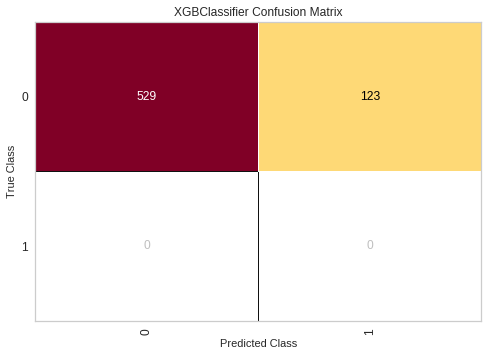

/home/lkonno/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


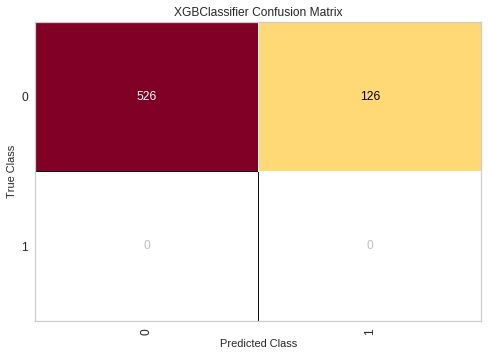

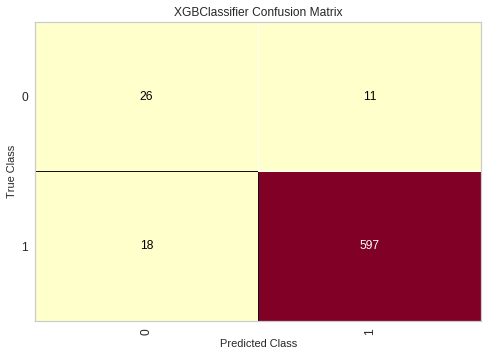

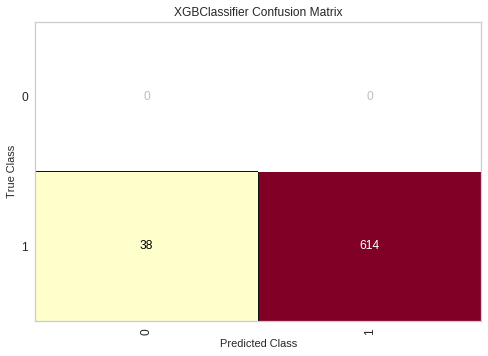

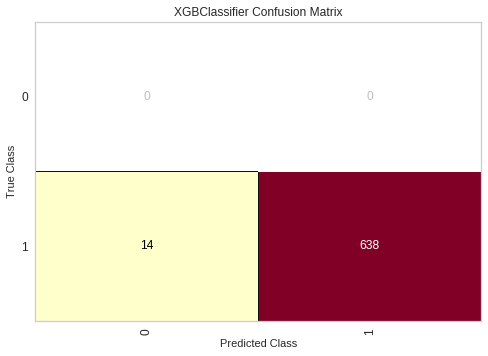

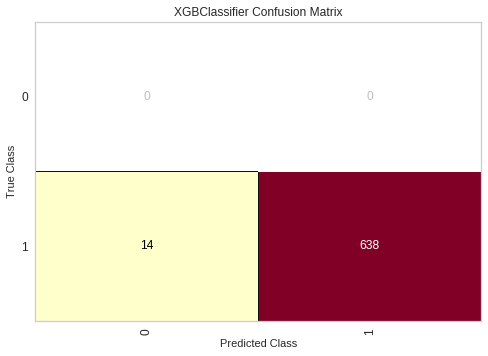

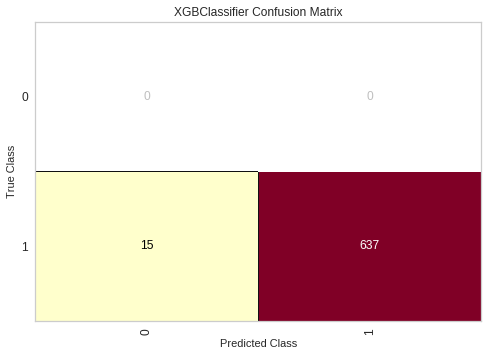

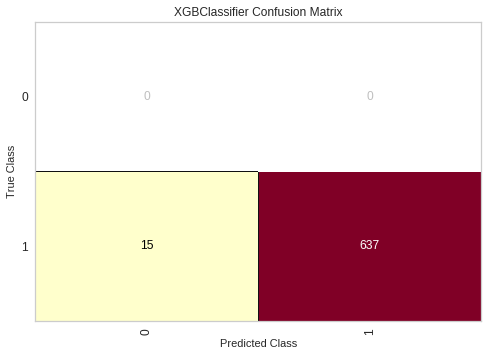

Accuracy mean: 0.92829754601227
Accuracy std: 0.06996517464687045
Recall mean: 0.727936555439174
Recall std: 0.4204292445893579
Precision mean: 0.7477384868421053
Precision std: 0.43174650492319677


In [31]:
score = []
recall = []
precision = []
    
for train, test in mycross.split(X_pca):    
   
    Xcross_train, ycross_train = X_pca[train], y[train]
    Xcross_test, ycross_test = X_pca[test], y[test]
       
    model.fit(Xcross_train, ycross_train)
    
    pred = model.predict(Xcross_test)
    
    #Confusion Matrix
    cm = ConfusionMatrix(model)
    cm.fit(Xcross_train, ycross_train)
    cm.score(Xcross_test, ycross_test)
    cm.show()
    
    score.append( accuracy_score(ycross_test, pred) )
    recall.append( recall_score(ycross_test, pred) )
    precision.append( precision_score(ycross_test, pred) )
   
    
else:
    print(f'Accuracy mean: {np.mean(score)}\nAccuracy std: {np.std(score)}')
    print(f'Recall mean: {np.mean(recall)}\nRecall std: {np.std(recall)}')
    print(f'Precision mean: {np.mean(precision)}\nPrecision std: {np.std(precision)}')

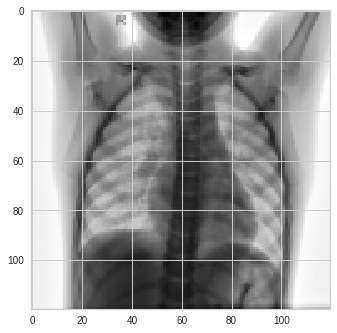

In [32]:
img = np.array(X.loc[0,::]).reshape((3,120,120))[0,:,:]

plt.imshow(img)

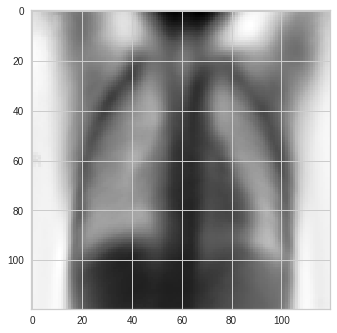

In [39]:
img = myPca.inverse_transform(X_pca[0]).reshape((3,120,120))[0,:,:]
plt.imshow(img)

In [40]:
#Fitando o dataset de teste completo!
model.fit(X_pca, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=4,
              min_child_weight=1, min_samples_leaf=3, min_samples_split=8,
              missing=None, n_estimators=500, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

# Realizando o teste no Dataset de teste:

In [41]:
#Trazendo o dataset de teste.
dataTest = image_to_df(testData)

640it [00:25, 25.06it/s]


In [42]:
dataTest.head()

,0,1,2,3,4,5,6,7,8,9,...,43191,43192,43193,43194,43195,43196,43197,43198,43199,target
0,0.121569,0.125490,0.121569,0.117647,0.113725,0.109804,0.109804,0.109804,0.109804,0.109804,...,0.113725,0.117647,0.121569,0.125490,0.125490,0.129412,0.129412,0.129412,0.125490,0
1,0.117647,0.117647,0.133333,0.266667,0.349020,0.415686,0.494118,0.529412,0.560784,0.572549,...,0.117647,0.117647,0.121569,0.125490,0.129412,0.129412,0.129412,0.129412,0.117647,0
2,0.141176,0.141176,0.137255,0.133333,0.133333,0.133333,0.129412,0.129412,0.129412,0.129412,...,0.098039,0.105882,0.109804,0.113725,0.121569,0.129412,0.133333,0.137255,0.129412,0
3,0.282353,0.298039,0.301961,0.329412,0.376471,0.372549,0.349020,0.368627,0.427451,0.482353,...,0.647059,0.623529,0.584314,0.541176,0.470588,0.462745,0.521569,0.529412,0.482353,0
4,0.152941,0.152941,0.149020,0.145098,0.141176,0.137255,0.133333,0.129412,0.125490,0.125490,...,0.164706,0.164706,0.164706,0.160784,0.160784,0.168627,0.168627,0.172549,0.168627,0


In [43]:
X_testFinal = dataTest.drop(columns='target')
y_testFinal = dataTest.target

In [44]:
X_pca_testFinal = pca.fit_transform(X_testFinal)

In [45]:
pred = model.predict(X_pca_testFinal)

In [50]:
from sklearn.metrics import accuracy_score

In [54]:
print(f'Recall: {recall_score(y_testFinal, pred):0.3f}')
print(f'Precision {precision_score(y_testFinal, pred):0.3f}')
print(f'F1 {f1_score(y_testFinal, pred):0.3f}')
print(f'Acurácia {accuracy_score(y_testFinal, pred):0.3f}')

Recall: 0.897
Precision 0.704
F1 0.789
Acurácia 0.702


In [47]:
from yellowbrick.classifier import ConfusionMatrix


/home/lkonno/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


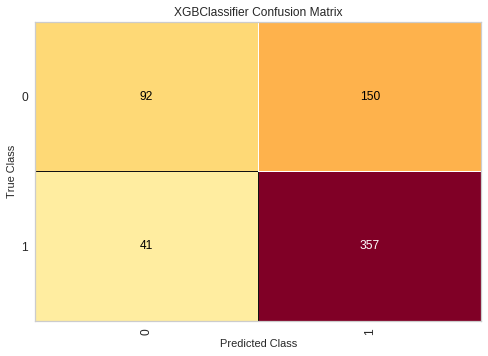

In [48]:
cm = ConfusionMatrix(model)
cm.fit(X_pca, y,)

cm.score(X_pca_testFinal, y_testFinal)

cm.show()

/home/lkonno/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


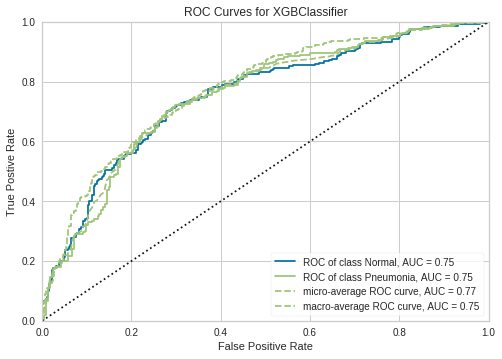

In [57]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(model, classes=["Normal", "Pneumonia"])

visualizer.fit(X_pca, y)        # Fit the training data to the visualizer
visualizer.score(X_pca_testFinal, y_testFinal)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

## Usando LightGBM

In [60]:
model2 = lgb.LGBMClassifier(random_state=42)
distributions = dict(max_depth = list(range(1,12)), n_estimators= [10,20,50,100,200,300,500,700,1000],
     min_samples_split=[2,3,4,6,8], min_samples_leaf=[1,2,3,4,5], learning_rate=[0.1,0.06,0.03,0.01,0.006,0.003])
search = RandomizedSearchCV(model2, distributions, verbose=1).fit(X_pca, y_train)
#search = clf.fit(X_pca, y_train)
search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.8min finished


{'n_estimators': 1000,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 5,
 'learning_rate': 0.1}

In [61]:
model2 = lgb.LGBMClassifier(n_estimators = 1000, min_samples_split = 4,
                                min_samples_leaf= 1, max_depth = 5,
                                learning_rate = 0.1, random_state = 42)


/home/lkonno/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


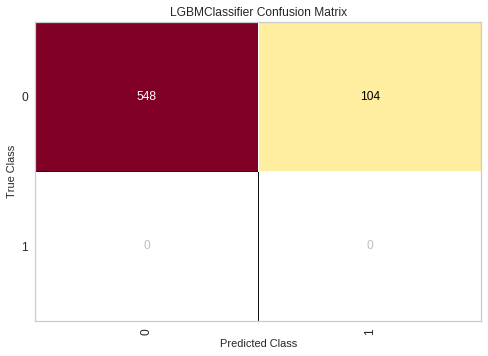

/home/lkonno/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lkonno/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


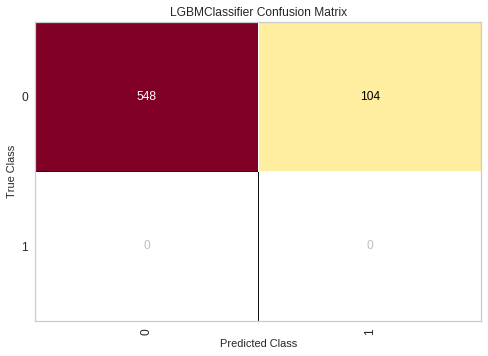

/home/lkonno/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lkonno/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


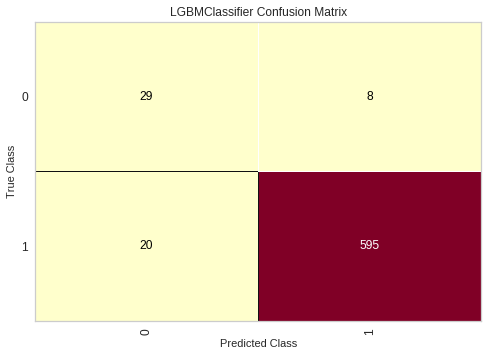

/home/lkonno/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


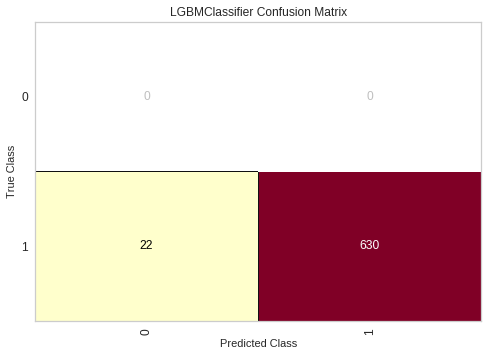

/home/lkonno/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


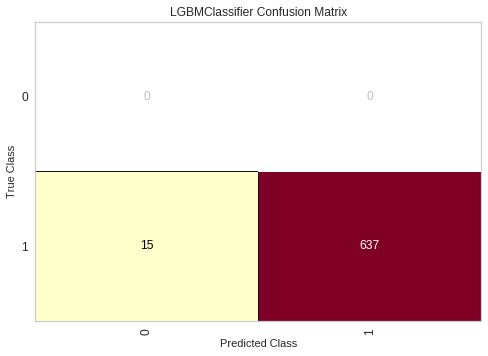

/home/lkonno/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


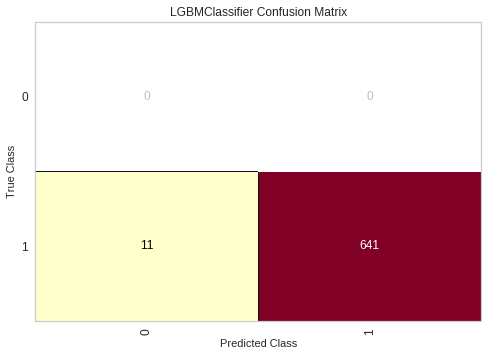

/home/lkonno/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


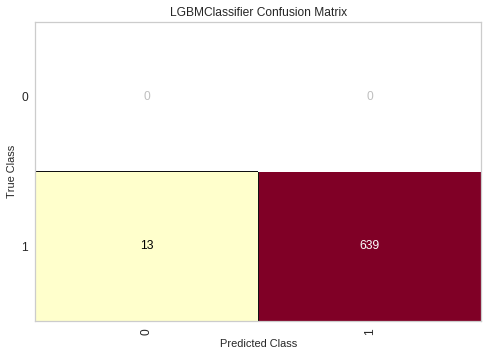

/home/lkonno/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


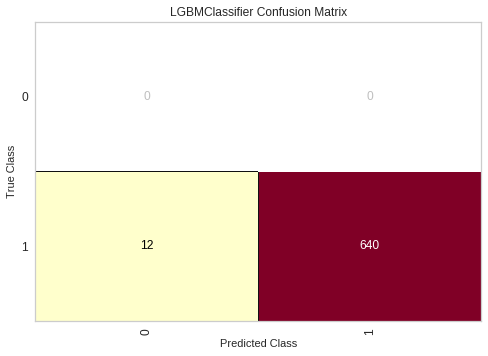

Accuracy mean: 0.9407592024539877
Accuracy std: 0.05846323949409771
Recall mean: 0.7319395605765874
Recall std: 0.4226250010191028
Precision mean: 0.7483416252072969
Precision std: 0.43207645625782476


In [62]:
#Cross Validation
score = []
recall = []
precision = []
    
for train, test in mycross.split(X_pca):    
   
    Xcross_train, ycross_train = X_pca[train], y_train[train]
    Xcross_test, ycross_test = X_pca[test], y_train[test]
       
    model2.fit(Xcross_train, ycross_train)
    
    pred = model2.predict(Xcross_test)
    
    #Confusion Matrix
    cm = ConfusionMatrix(model2)
    cm.fit(Xcross_train, ycross_train)
    cm.score(Xcross_test, ycross_test)
    cm.show()
    
    score.append( accuracy_score(ycross_test, pred) )
    recall.append( recall_score(ycross_test, pred) )
    precision.append( precision_score(ycross_test, pred) )
   
    
else:
    print(f'Accuracy mean: {np.mean(score)}\nAccuracy std: {np.std(score)}')
    print(f'Recall mean: {np.mean(recall)}\nRecall std: {np.std(recall)}')
    print(f'Precision mean: {np.mean(precision)}\nPrecision std: {np.std(precision)}')

In [63]:
model2.fit(X_pca, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_samples_leaf=1,
               min_samples_split=4, min_split_gain=0.0, n_estimators=1000,
               n_jobs=-1, num_leaves=31, objective=None, random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [64]:
pred = model2.predict(X_pca_testFinal)

In [65]:
from sklearn.metrics import accuracy_score

In [66]:
print(f'Recall: {recall_score(y_testFinal, pred):0.3f}')
print(f'Precision {precision_score(y_testFinal, pred):0.3f}')
print(f'F1 {f1_score(y_testFinal, pred):0.3f}')
print(f'Acurácia {accuracy_score(y_testFinal, pred):0.3f}')

Recall: 0.892
Precision 0.703
F1 0.786
Acurácia 0.698


/home/lkonno/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


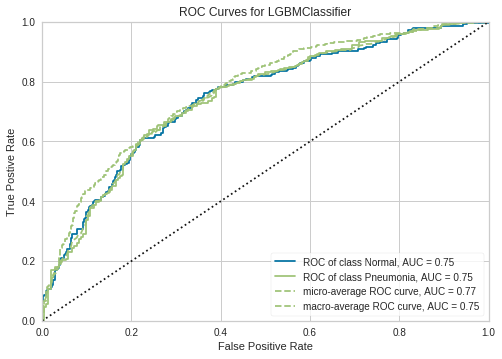

In [67]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(model2, classes=["Normal", "Pneumonia"])

visualizer.fit(X_pca, y_train)        # Fit the training data to the visualizer
visualizer.score(X_pca_testFinal, y_testFinal)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure